# T687861 | D-Optimal Online Experiment Design for Recommender Selection

## Executive summary

| | |
| --- | --- |
| Problem | Traditional A/B testing method for model selection is slow and costly. |
| Hypothesis | Selecting the optimal recommender via online exploration-exploitation is better than the traditional A/B testing, as this traditional method can be slow and costly, and offline evaluations are prone to the bias of history data. |
| Solution | Leverage the D-optimal design from the classical statistics literature to achieve the maximum information gain during exploration. Data-generating mechanism - In the beginning stage, 10% of the full data is selected as the training data to fit the candidate recommendation models, and the rest of the data is treated as the testing set which generates the interaction data adaptively. The procedure can be described as follow. In each epoch, we recommend one item to each user. If the item has received a non-zero rating from that particular user in the testing data, we move it to the training data and endow it with a positive label if the rating is high, e.g. ≥ 3 under the five-point scale. Otherwise, we add the item to the rejection list and will not recommend it to this user again. After each epoch, we retrain the candidate models with both the past and the newly collected data. Candidate models - user-based CF, item-based CF, ItemPop, MF. |
| Dataset | ML-1m |
| Preprocessing | The movie ratings are binarized to {0, 1}, i.e. ≥ 2.5 or < 2.5, and we use the metadata of movies and users as the contextual information for the reward model. In particular, we perform the one-hot transformation for the categorical data to obtain the feature mappings 𝝓(·). For text features such as movie title, we train a word embedding model with 50 dimensions. The final representation is obtained by concatenating all the one-hot encoding and embedding. |
| Metrics | Cumulative Recall (the ratio of the total number of successful recommendations (up to the current epoch) against the total number of positive rating in the testing data). |
| Cluster | Platform - Python 3, Lib - gensim, acgan. |
| Tags | `OnlineEvaluation`, `MultiArmedBandit`, `MovieLens`, `Simulation` |
| Links | [Paper (arXiv)](https://arxiv.org/abs/2110.12132v1), [Repo (git)](https://github.com/RecoHut-Stanzas/S691423) |

## Process flow

<img src='https://github.com/RecoHut-Stanzas/S691423/raw/main/images/process_flow_main.svg'>

## Setup

### Install acgan library

In [ ]:
!mkdir acganlib && git clone https://github.com/richardruancw/Adversarial-Counterfactual-Learning-and-Evaluation-for-Recommender-System.git acganlib
!cd acganlib && pip install .

### Download ML-1m dataset

In [ ]:
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


### Import required libraries

In [ ]:
from __future__ import annotations
from typing import Dict, Any, List, Set, Tuple, Optional, Union, cast

import os 
import json
import time
from pathlib import Path
from tqdm import tqdm
import sys
import random 

import numpy as np
import pandas as pd
from scipy import sparse as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import gensim
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from acgan.recommender import Recommender
from acgan.recommender import PopRecommenderV2, SVDRecommenderV2, UserBasedKnn, ContextItemKnn

### Params

In [ ]:
# numpy floating-point precision
np.set_printoptions(precision=4)

# create output folder to store plots and json results
Path('./output').mkdir(parents=True, exist_ok=True)

In [ ]:
class Args:
    """default arguments"""
    dim = 20
    topk = 1
    num_epochs = 10 # recommender 200 for optimal performance
    epsilon = 0.1
    explore_step = 500
    feat_map = 'onehot_context' # choices=['onehot', 'context', 'armed_context', 'onehot_context']
    algo = 'lin_ct' # choices=['base', 'e_greedy', 'thompson', 'lin_ct', 'optimal']

args = Args()

### Config

Taking inputs from user.

In [ ]:
args.dim = int(input('Embedding dimensions (default=20,type=int):') or '20')

args.topk = int(input('Top-K (default=1,type=int):') or '1')

args.num_epochs = int(input('No. of epochs (default=10,recommended=200,type=int):') or '10')

args.epsilon = float(input('Epsilon (default=0.1,type=float,range=0-1):') or '0.1')

args.explore_step = int(input('explore_step (default=500,type=int):') or '500')

args.feat_map = input('feat_map (default=onehot_context,choices=onehot/context/armed_context/onehot_context,type=str):') or 'onehot_context'
assert(args.feat_map in 'onehot/context/armed_context/onehot_context'.split('/')), 'Invalid feat_map'

args.algo = input('algo (default=lin_ct,choices=base/e_greedy/thompson/lin_ct/optimal,type=str):') or 'lin_ct'
assert(args.algo in 'base/e_greedy/thompson/lin_ct/optimal'.split('/')), 'Invalid algo'

print('Running on these Params: {}'.format([{k:v} for k,v in dict(Args.__dict__).items() if not k.startswith('__')]))

## Preprocessing

We need to generate the movies and users features before running the simulations.

In [ ]:
data_path='ml-1m'
names = ['uidx', 'iidx', 'rating', 'ts']
dtype = {'uidx':int, 'iidx':int, 'rating':float, 'ts':float}
data_df = pd.read_csv(os.path.join(data_path, 'ratings.dat'), sep='::', names=names, dtype=dtype, engine='python')

In [ ]:
# rating 4.0,5.0 -> 1.0, and 1.0,2.0,3.0 -> 0.0
data_df['rating'] = (data_df['rating'] >= 4).astype(np.float32)

user_num, item_num = data_df.uidx.max() + 1, data_df.iidx.max() + 1
print('Before label encoding/correction: user_num={}, item_num={}'.format(user_num, item_num))

uidx_encoder = LabelEncoder()
iidx_encoder = LabelEncoder()
data_df.uidx = uidx_encoder.fit_transform(data_df.uidx)
data_df.iidx = iidx_encoder.fit_transform(data_df.iidx)

user_num, item_num = data_df.uidx.max() + 1, data_df.iidx.max() + 1

print(len(uidx_encoder.classes_))
print('After label encoding/correction: user_num={}, item_num={}'.format(user_num, item_num))
data_df.to_feather(os.path.join(data_path, 'ratings.feather'))

6041 3953
6040
6040 3706


In [ ]:
def movie():
    # feature engineering for movies
    train_corpus = []
    with open(os.path.join(data_path, 'movies.dat'), encoding='ISO-8859-1') as f:
        for line in f:
            iidx_raw, title_raw, genre_raw = line.strip().split('::')
            try:
                iidx = int(iidx_encoder.transform([int(iidx_raw)])[0])
            except ValueError:
                continue
            genre_str = genre_raw.strip().replace('|', ' ')
            doc = simple_preprocess(title_raw + genre_str)
            train_corpus.append(TaggedDocument(doc, [iidx]))

    model = Doc2Vec(vector_size=50, min_count=2, epochs=20)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    context_embedding = np.zeros((item_num, 50))
    for i in range(item_num):
        context_embedding[i, :] = model.docvecs.vectors_docs[i]
    np.save(os.path.join(data_path,'item_feat.npy'), context_embedding)

In [ ]:
movie()

In [ ]:
def user():
    # feature engineering for users
    # UserID::Gender::Age::Occupation::Zip-code
    gender_set = set()
    occu_set = set()
    zipcode_set = set()
    age_set = set()
    data = []
    max_idx = 0
    with open(os.path.join(data_path, 'users.dat'), encoding='ISO-8859-1') as f:
        for line in f:
            puidx, gender, age, occupation, zipcode = line.strip().split('::')
            uidx = uidx_encoder.transform([int(puidx)])[0]
            
            max_idx = max(max_idx, uidx)
            # assert(uidx < user_num)
            gender_set.add(gender)
            age_set.add(age)
            occu_set.add(occupation)
            zipcode_set.add(zipcode)
            data.append([uidx, gender, age, occupation, zipcode])
    print(max_idx)
    gender_encoder = LabelEncoder().fit(list(gender_set))
    gender_feat = np.zeros((user_num, len(gender_set)))

    age_encoder = LabelEncoder().fit(list(age_set))
    age_feat = np.zeros((user_num, len(age_set)))

    occu_encoder = LabelEncoder().fit(list(occu_set))
    occu_feat = np.zeros((user_num, len(occu_set)))

    zipcode_encoder = LabelEncoder().fit(list(zipcode_set))
    zipcode_feat = np.zeros((user_num, len(zipcode_set)))

    for uidx, gender, age, occupation, zipcode in data:
        gender = gender_encoder.transform([gender])[0]
        gender_feat[uidx, gender] += 1

        age = age_encoder.transform([age])[0]
        age_feat[uidx, age] += 1

        occupation = occu_encoder.transform([occupation])[0]
        occu_feat[uidx, age] += 1

        zipcode = zipcode_encoder.transform([zipcode])[0]
        zipcode_feat[uidx, zipcode] += 1

    user_context = np.concatenate([gender_feat, age_feat, occu_feat], axis=1)
    print(f'user_context shape: {user_context.shape}')
    np.save(os.path.join(data_path,'user_feat.npy'), user_context)

In [ ]:
user()

6039
user_context shape: (6040, 30)


## Bandits

In [ ]:
BanditData = List[Tuple[int, float, Any]]

In [ ]:
class Bandit:
    def __init__(self, recom_list: List[Recommender]):
        self.recom_list = recom_list
        self.k = len(self.recom_list)

    def get_arm(self, arm: int) -> Recommender:
        return self.recom_list[arm]

In [ ]:
class BanditAlgorithm:
    """Implement the interfaces for any bandit algorithms evaluated."""
    def __init__(self, num_arms: int, rng: Optional[np.random.RandomState] = None):
        self.num_arms = num_arms
        if rng is None:
            self.rng = np.random.RandomState()
        self.total_reward_per_arm = np.zeros(num_arms)
        self.total_cnt_per_arm = np.zeros(num_arms)
        self.curr_cnt_per_arm = np.zeros(num_arms)
        self.avg_reward_per_arm = np.zeros(num_arms)
        self.arm_arr = np.arange(num_arms)

    def predict(self, *args, **kwds) -> int:
        """Return the estimated return for contextual bandit"""
        raise NotImplementedError()

    def update(self, data: BanditData):
        """Update the algorithms based on observed (action, reward, context)"""
        raise NotImplementedError()

    def record_metric(self, data: BanditData):
        """Record the cumulative performance metrics for this algorithm"""
        self.curr_cnt_per_arm *= 0
        for arm, reward, _ in data:
            self.total_reward_per_arm[arm] += reward
            self.total_cnt_per_arm[arm] += 1
            self.curr_cnt_per_arm[arm] += 1
        valid = self.total_cnt_per_arm > 0
        self.avg_reward_per_arm[valid] = self.total_reward_per_arm[valid] / self.total_cnt_per_arm[valid]

In [ ]:
class RandomBandit(BanditAlgorithm):
    def __init__(self, num_arms: int):
        super(RandomBandit, self).__init__(num_arms)

    def update(self, data: BanditData):
        pass

    def predict(self):
        return int(self.rng.randint(0, self.num_arms))

In [ ]:
class EpsilonGreedy(BanditAlgorithm):
    def __init__(self, num_arms: int, epsilon: float):
        super(EpsilonGreedy, self).__init__(num_arms)
        self.epsilon = epsilon

    def update(self, data: BanditData):
        pass

    def predict(self):
        if self.rng.rand() <= self.epsilon: # exploration
            arm = self.rng.randint(0, self.num_arms)
        else: # exploitation - pull the best arm
            max_value = self.avg_reward_per_arm.max()
            best_arms = self.arm_arr[self.avg_reward_per_arm == max_value]
            if (best_arms).sum() > 1:
                #break ties randomly
                arm = best_arms[np.random.randint(0, len(best_arms))]
            else:
                arm = best_arms[0]
        return arm 

In [ ]:
class ThompsonSampling(BanditAlgorithm):
    def __init__(self, num_arms: int):
        super(ThompsonSampling, self).__init__(num_arms)
        # alpha,beta are params for beta-distribution, just like mu,siga for normal-distribution
        self.alpha = np.ones(num_arms) * 1000
        self.beta = np.ones(num_arms)

    def update(self, data: BanditData):
        for arm, reward, _ in data:
            if reward > 0:
                self.alpha[arm] += 1
            else:
                self.beta[arm] += 1

    def predict(self):
        theta = self.rng.beta(self.alpha, self.beta)
        max_value = theta.max()
        best_arms = self.arm_arr[theta == max_value]
        if (best_arms).sum() > 1:
            #break ties randomly
            arm = best_arms[np.random.randint(0, len(best_arms))]
        else:
            arm = best_arms[0]
        return arm

In [ ]:
class Contextual(BanditAlgorithm):
    def __init__(self, num_arms: int, feat_dim: int, lambda_: float = 0.001, ucb_weight: float = 0.00):
        super(Contextual, self).__init__(num_arms)
        self.feat_dim = feat_dim
        self.ucb_weight = ucb_weight
        self.context_cov = np.zeros((feat_dim, feat_dim))
        self.cumu_feat = np.zeros(feat_dim)
        self.theta = np.zeros(feat_dim)
        self.inv_v = np.eye(feat_dim)
        self.lambda_I = lambda_ * np.eye(feat_dim)

    def predict(self, feature):
        rest = self.theta.dot(feature) 
        if self.ucb_weight > 0.0001:
            rest += self.ucb_weight * np.sqrt(feature.dot(self.inv_v).dot(feature))
        return rest

    def update(self, data: BanditData):
        for arm, reward, feature in data:
            self.cumu_feat += feature * reward
            self.context_cov += feature.reshape(-1, 1).dot(feature.reshape(1, -1))
        #self.theta = np.linalg.solve(self.lambda_I + self.context_cov, self.cumu_feat)
        self.inv_v = np.linalg.inv(self.lambda_I + self.context_cov)
        self.theta = self.inv_v.dot(self.cumu_feat)

In [ ]:
class OptimalDesign(BanditAlgorithm):
    def __init__(self, num_arms: int, feat_dim: int, lambda_: float = 0.001, ucb_weight: float = 0.00):
        super(OptimalDesign, self).__init__(num_arms)
        self.feat_dim = feat_dim
        self.ucb_weight = ucb_weight
        self.lambda_I = lambda_ * np.eye(feat_dim)
        self.context_cov = np.zeros((feat_dim, feat_dim))
        self.cumu_feat = np.zeros(feat_dim)
        self.theta = np.random.rand(feat_dim)
        self.clear_buffer()

    def predict(self, feature):
        """Predict the reward for the arm
        """
        return self.theta.dot(feature) + self.ucb_weight * np.sqrt(feature.dot(self.inv_v).dot(feature))

    def update(self, data: BanditData):
        """Update prediction perameters
        """
        #self.theta = np.linalg.solve(self.lambda_I + self.context_cov, self.cumu_feat)
        for arm, reward, feature in data:
            self.cumu_feat += feature * reward
            self.context_cov += feature.reshape(-1, 1).dot(feature.reshape(1, -1))
        self.inv_v = np.linalg.inv(self.lambda_I + self.context_cov)
        self.theta = self.inv_v.dot(self.cumu_feat)

    def clear_buffer(self):
        feat_dim = self.feat_dim
        self.explore_context_cov = np.zeros((feat_dim, feat_dim))
        self.context_cov = np.zeros((feat_dim, feat_dim))
        self.cumu_feat = np.zeros(feat_dim)
        #self.inv_v = np.eye(feat_dim)
    
    def explore_decision(self, feat_mat: np.ndarray) -> int:
        """Find the arm that maximize the log(det(V(pi)))
        """
        det_v_arr = np.zeros(self.num_arms)
        for arm in range(self.num_arms):
            feature = feat_mat[arm, :]
            det_v_arr[arm] = np.linalg.det(self.lambda_I + self.explore_context_cov + feature.reshape(-1, 1).dot(feature.reshape(1, -1)))
        
        arm = det_v_arr.argmax()
        feature = feat_mat[arm, :]
        self.explore_context_cov += feature.reshape(-1, 1).dot(feature.reshape(1, -1))
        return arm

## Environment

In [ ]:
class Environment:
    def __init__(self, user_num: int, item_num: int, data_df: pd.DataFrame, init_ratio: float = 0.05):
        # sample initial data and build user history profile.
        self.user_num = user_num
        self.item_num = item_num
        self.item_candidate = list(range(item_num))
        self.data_df = data_df
        self.user_full_hist_dict = data_df.groupby('uidx').apply(lambda x: set(x.iidx)).to_dict()
        self.curr_df = data_df.sample(n=int(data_df.shape[0] * 0.05))
        self.init_test_relevant_size = self.data_df[self.data_df.rating > 0].shape[0] - self.curr_df.shape[0]

        self.user_curr_hist_dict = self.curr_df.groupby('uidx').apply(lambda x: set(x.iidx)).to_dict()
        self.user_curr_reject_dict: Dict[int, Set[int]] = {}

        self.rating_dict = {(uidx, iidx):rating for uidx, iidx, rating in zip(data_df.uidx, data_df.iidx, data_df.rating)}
        assert(len(self.rating_dict) == len(data_df))

        print(f'avg_user_hist_length: {np.mean([len(v) for v in self.user_full_hist_dict.values()])}')
        print(f'avg_user_init_hist_length: {np.mean([len(v) for v in self.user_curr_hist_dict.values()])}')

        print(self.curr_df.groupby('uidx').count().iidx.mean())
        print('build initial recall set')
        self.user_recall_dict: Dict[int, List[int]] = {}
        for uidx in self.user_full_hist_dict.keys():
            self.user_recall_dict[uidx] = self.item_candidate.copy()
        print('--initial filter')
        for uidx in self.user_recall_dict.keys():
            past_set = self.user_curr_hist_dict.get(uidx, set())
            self.user_recall_dict[uidx] = [x for x in self.user_recall_dict[uidx] if x not in past_set]

    def get_epoch(self, shuffle: bool = True):
        return EpochIter(self, shuffle)

    def action(self, uidx: int, recommendations: List[int]) -> float:
        num_match = 0
        for item in recommendations:
            assert(item not in self.user_curr_hist_dict.get(uidx, []))
            assert(item not in self.user_curr_reject_dict.get(uidx, []))
            if item in self.user_full_hist_dict[uidx]:
                # mark as positive if the user has positive feedbacks in the test and add to history
                num_match += self.rating_dict[(uidx, item)]
                if uidx not in self.user_curr_hist_dict:
                    self.user_curr_hist_dict[uidx] = set()
                self.user_curr_hist_dict[uidx].add(item)
            else:
                # include to the user's reject history so that dont recommend it again
                if uidx not in self.user_curr_reject_dict:
                    self.user_curr_reject_dict[uidx] = set()
                self.user_curr_reject_dict[uidx].add(item)
        reward = float(num_match > 0)
        return reward

    def _update_recall(self):
        #update the user recall set
        print('filter recall at the end of epoch')
        for uidx in self.user_recall_dict.keys():
            reject_set = self.user_curr_reject_dict.get(uidx, set())
            past_set = self.user_curr_hist_dict.get(uidx, set())
            self.user_recall_dict[uidx] = [x for x in self.user_recall_dict[uidx] if x not in reject_set and x not in past_set]
        avg_recall_length = np.mean([len(v) for v in self.user_recall_dict.values()])

    def get_train(self):
        #re-build the data-frame
        u_list, i_list = [], []
        for uidx, item_set in self.user_curr_hist_dict.items():
            u_list.extend([uidx] * len(item_set))
            i_list.extend(list(item_set))
        new_df = pd.DataFrame({'uidx': u_list, 'iidx': i_list, 
        'rating': np.ones(len(u_list)), 'ts': np.ones(len(u_list))})
        return new_df

In [ ]:
class EpochIter:
    def __init__(self, env: Environment, shuffle: bool):
        self.env = env
        self.user_lists = list(env.user_full_hist_dict.keys())
        self.ptr = 0
        self.shuffle = shuffle

    def __next__(self) -> Tuple[int, List[int]]:
        if self.ptr < len(self.user_lists):
            user = self.user_lists[self.ptr]
            self.ptr += 1
        else:
            self.env._update_recall()
            raise StopIteration()
        return user, self.env.user_recall_dict[user]

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.user_lists)
        return self

    def __len__(self):
        return len(self.user_lists)

For each user, we runs the `get_epoch` method, which returns a refreshed simulator based on the last interaction with the user.

## Feature

In [ ]:
class FeatureMap:
    def __init__(self) -> None:
        self.dim = -1
    def __call__(self, arm:int, user:int, recommendations: List[int], ) -> np.ndarray:
        raise NotImplementedError()

In [ ]:
class ArmOneHot(FeatureMap):
    def __init__(self, num_arm: int) -> None:
        self.num_arm = num_arm
        self._cand_slot = np.eye(num_arm)
        self.dim = num_arm

    def __call__(self, arm:int, user:int, recommendations: List[int], ) -> np.ndarray:
        return self._cand_slot[arm, :]

In [ ]:
class ConcatContext(FeatureMap):
    def __init__(self, num_arms: int, user_embed: np.ndarray, item_embed: np.ndarray):
        self.num_arms = num_arms
        user_embed = user_embed[:, user_embed.std(0) > 0]
        item_embed = item_embed[:, item_embed.std(0) > 0]
        self.user_embed = (user_embed - user_embed.mean(0)) / user_embed.std(0)
        self.item_embed = (item_embed - item_embed.mean(0)) / item_embed.std(0)
        self.dim = self.item_embed.shape[1] + self.user_embed.shape[1]
        print(self.dim)

    def __call__(self, arm:int, user:int, recommendations: List[int], ) -> np.ndarray:
        # item_dim = self.item_embed.shape[1]
        if len(recommendations) > 1:
            recom_pool = self.item_embed[recommendations, :].sum(0) 
        else:
            recom_pool = self.item_embed[recommendations[0], :] 
        return np.concatenate([self.user_embed[user], recom_pool], axis=0)

In [ ]:
class ArmedConcatContext(FeatureMap):
    def __init__(self, num_arms: int, user_embed: np.ndarray, item_embed: np.ndarray):
        self.num_arms = num_arms
        user_embed = user_embed[:, user_embed.std(0) > 0]
        item_embed = item_embed[:, item_embed.std(0) > 0]
        self.user_embed = (user_embed - user_embed.mean(0)) / user_embed.std(0)
        self.item_embed = (item_embed - item_embed.mean(0)) / item_embed.std(0)
        self.dim = num_arms * self.item_embed.shape[1] + self.user_embed.shape[1]
        print(self.dim)

    def __call__(self, arm:int, user:int, recommendations: List[int], ) -> np.ndarray:
        item_dim = self.item_embed.shape[1]
        if len(recommendations) > 1:
            recom_pool = self.item_embed[recommendations, :].sum(0) 
        else:
            recom_pool = self.item_embed[recommendations[0], :] 
        arm_anchor_feat = np.zeros(self.num_arms * item_dim)
        arm_anchor_feat[arm*item_dim:(arm + 1)*item_dim] = recom_pool
        return np.concatenate([self.user_embed[user], arm_anchor_feat], axis=0)

In [ ]:
class ArmOneHotWithContext(FeatureMap):
    def __init__(self, num_arms: int, user_embed: np.ndarray, item_embed: np.ndarray):
        self.concat_context = ConcatContext(num_arms, user_embed, item_embed)
        self.arm_onehot = ArmOneHot(num_arms)
        self.dim = self.concat_context.dim + self.arm_onehot.dim

    def __call__(self, arm:int, user:int, recommendations: List[int], ) -> np.ndarray:
        f1 = self.concat_context(arm, user, recommendations)
        f2 = self.arm_onehot(arm, user, recommendations)
        return np.concatenate([f1, f2], axis=0)

## Simulations

In [ ]:
def run_basic(env: Environment, algo: BanditAlgorithm, bandit_ins: Bandit, args: Args): 
    num_epochs=args.num_epochs
    top_k=args.topk
    epoch_record: Dict[str, Any] = {'epoch':[], 'cumu_recall': []}
    epoch_record['recommenders'] = [x.__class__.__name__ for x in bandit_ins.recom_list]
    epoch_record['bandit_algorithm'] = algo.__class__.__name__

    for epoch in range(num_epochs):
        # train the recommendation models
        new_train_data = env.get_train()
        for recom in bandit_ins.recom_list:
            recom.fit(new_train_data)

        data: BanditData = []
        for uidx, recall_set in env.get_epoch():
            arm = algo.predict()
            recommendations = bandit_ins.get_arm(arm).recommend(uidx, recall_set, top_k)
            reward = env.action(uidx, recommendations)
            data.append((arm, reward, None))
        algo.update(data)
        algo.record_metric(data)

        cumu_recall = algo.total_reward_per_arm.sum() / env.init_test_relevant_size
        print(f'epoch: {epoch}, cumulative recall: {cumu_recall}, arm_cnt: {algo.total_cnt_per_arm}, curr_arm: {algo.curr_cnt_per_arm}')
        epoch_record['epoch'].append(epoch)
        epoch_record['cumu_recall'].append(cumu_recall)
    return epoch_record

In [ ]:
def run_lin_contextual(env: Environment, algo: BanditAlgorithm, bandit_ins: Bandit, feat_map: FeatureMap , args: Args): 
    num_epochs=args.num_epochs
    top_k=args.topk
    epoch_record: Dict[str, Any] = {'epoch':[], 'cumu_recall': []}
    epoch_record['recommenders'] = [x.__class__.__name__ for x in bandit_ins.recom_list]
    epoch_record['bandit_algorithm'] = algo.__class__.__name__

    est_list = np.zeros(algo.num_arms)
    feat_mat = np.zeros((algo.num_arms, feat_map.dim))
    recommendations_mat: List[List[int]] = [[] for _ in range(algo.num_arms)]

    for epoch in range(num_epochs):
        # train the recommendation models
        new_train_data = env.get_train()
        for recom in bandit_ins.recom_list:
            recom.fit(new_train_data)

        data: BanditData = []
        for uidx, recall_set in env.get_epoch():
            for arm in range(algo.num_arms):
                recommendations_mat[arm] = bandit_ins.get_arm(arm).recommend(uidx, recall_set, top_k)
                feature = feat_map(arm, uidx, recommendations_mat[arm])
                est_list[arm] = algo.predict(feature)
                feat_mat[arm, :] = feature

            max_value = est_list.max()
            best_arms = algo.arm_arr[est_list == max_value]
            if (best_arms).sum() > 1:
                #break ties randomly
                arm = best_arms[np.random.randint(0, len(best_arms))]
            else:
                arm = best_arms[0]
            #recommendations = bandit.get_arm(arm).recommend(uidx, recall_set, top_k)
            reward = env.action(uidx, recommendations_mat[arm])
            data.append((arm, reward, feat_mat[arm, :]))
        algo.update(data)
        algo.record_metric(data)

        cumu_recall = algo.total_reward_per_arm.sum() / env.init_test_relevant_size
        print(f'epoch: {epoch}, cumulative recall: {cumu_recall}, arm_cnt: {algo.total_cnt_per_arm}, curr_arm: {algo.curr_cnt_per_arm}')
        epoch_record['epoch'].append(epoch)
        epoch_record['cumu_recall'].append(cumu_recall)
    return epoch_record

In [ ]:
def run_optimal_contextual(env: Environment, algo: OptimalDesign, bandit_ins: Bandit, feat_map: FeatureMap, args: Args):
    num_epochs:int =args.num_epochs
    top_k: int=args.topk
    explore_step: int=args.explore_step
    epoch_record: Dict[str, Any] = {'epoch':[], 'cumu_recall': []}
    epoch_record['recommenders'] = [x.__class__.__name__ for x in bandit_ins.recom_list]
    epoch_record['bandit_algorithm'] = algo.__class__.__name__

    est_list = np.zeros(algo.num_arms)
    feat_mat = np.zeros((algo.num_arms, feat_map.dim))
    recommendations_mat: List[List[int]] = [[] for _ in range(algo.num_arms)]

    for epoch in range(num_epochs):
        # train the recommendation models using latest trainning data
        new_train_data = env.get_train()
        for recom in bandit_ins.recom_list:
            recom.fit(new_train_data)

        data: BanditData = []
        explore_data: BanditData = []
        explore_cnt = 0
        wait_explore_update = True

        #algo.clear_buffer()
        for uidx, recall_set in env.get_epoch():
            # update the theta if has done enough exploration
            if explore_cnt >= explore_step and wait_explore_update:
                algo.update(explore_data)
                wait_explore_update = False
            
            # get system output
            for arm in range(algo.num_arms):
                recommendations_mat[arm] = bandit_ins.get_arm(arm).recommend(uidx, recall_set, top_k)
                feat_mat[arm, :] = feat_map(arm, uidx, recommendations_mat[arm])

            # explore or exploit
            if explore_cnt < explore_step:
                #explore to maximize the information gain
                arm = algo.explore_decision(feat_mat)
            else:
                for arm in range(algo.num_arms):
                    est_list[arm] = algo.predict(feat_mat[arm, :])
                # interact with environment, add record
                max_value = est_list.max()
                best_arms = algo.arm_arr[est_list == max_value]
                if (best_arms).sum() > 1:
                    #break ties randomly
                    arm = best_arms[np.random.randint(0, len(best_arms))]
                else:
                    arm = best_arms[0]
            #recommendations = bandit.get_arm(arm).recommend(uidx, recall_set, top_k)
            reward = env.action(uidx, recommendations_mat[arm])
            data.append((arm, reward, feat_mat[arm, :]))

            if explore_cnt < explore_step:
                explore_data.append((arm, reward, feat_mat[arm, :]))
            explore_cnt += 1
        
        # update metric at the end epoch, no need to update parameters
        algo.record_metric(data)

        cumu_recall = algo.total_reward_per_arm.sum() / env.init_test_relevant_size
        print(f'epoch: {epoch}, cumulative recall: {cumu_recall}, arm_cnt: {algo.total_cnt_per_arm}, curr_arm: {algo.curr_cnt_per_arm}')
        epoch_record['epoch'].append(epoch)
        epoch_record['cumu_recall'].append(cumu_recall)
    return epoch_record

## Running simulations

In [ ]:
user_embed = np.load('./ml-1m/user_feat.npy')
item_embed = np.load('./ml-1m/item_feat.npy')
data_df = pd.read_feather('./ml-1m/ratings.feather')
user_num, item_num = data_df.uidx.max() + 1, data_df.iidx.max() + 1
assert(max(data_df.rating) == 1)
assert(min(data_df.rating) == 0)
print('average overall rating: {:.4f}'.format(data_df.rating.mean()))
print('user_num:{}, item_num:{}'.format(user_num, item_num))

average overall rating: 0.575160801410675
6040 3706


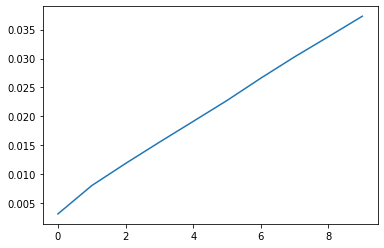

In [ ]:
sv_recom = SVDRecommenderV2(user_num, item_num, args.dim)
pop_recom = PopRecommenderV2(user_num, item_num)
uknn_recom = UserBasedKnn(user_num, item_num)
item_knn_recom = ContextItemKnn(user_num, item_num, item_embed)

recom_model_list = [item_knn_recom, pop_recom, sv_recom]

num_arms = len(recom_model_list)
bandit_ins = Bandit(recom_model_list)


feature_map: FeatureMap
if args.feat_map == 'onehot':
    feature_map = ArmOneHot(num_arms)
elif args.feat_map == 'context':
    feature_map = ConcatContext(num_arms, user_embed, item_embed)
elif args.feat_map == 'armed_context':
    feature_map = ArmedConcatContext(num_arms, user_embed, item_embed)
elif args.feat_map == 'onehot_context':
    feature_map = ArmOneHotWithContext(num_arms, user_embed, item_embed)


bandit_algo: BanditAlgorithm
if args.algo == 'base':
    bandit_algo = RandomBandit(num_arms)
elif args.algo == 'e_greedy':
    bandit_algo = EpsilonGreedy(num_arms, args.epsilon)
elif args.algo == 'thompson':
    bandit_algo = ThompsonSampling(num_arms)
elif args.algo == 'lin_ct':
    bandit_algo = Contextual(num_arms, feature_map.dim)
elif args.algo == 'optimal':
    bandit_algo = OptimalDesign(num_arms, feature_map.dim)
else:
    raise ValueError('no known algorithms')


env = Environment(user_num, item_num, data_df)
if args.algo == 'lin_ct':
    epoch_record = run_lin_contextual(env, bandit_algo, bandit_ins, feature_map, args)
elif args.algo == 'optimal':
    bandit_algo = cast(OptimalDesign, bandit_algo)
    epoch_record = run_optimal_contextual(env, bandit_algo, bandit_ins, feature_map, args)
else:
    epoch_record = run_basic(env, bandit_algo, bandit_ins, args)  

record_name = f'{bandit_algo.__class__.__name__}_{time.time()}'
with open(f'output/{record_name}.json', 'w') as f:
    json.dump(epoch_record, f)

plt.plot(epoch_record['epoch'], epoch_record['cumu_recall'])
plt.savefig(f'{record_name}_plt.jpg')

---

In [ ]:
# !apt-get -qq install tree
# !rm -r sample_data

Selecting previously unselected package tree.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
# !tree -h --du .

.
├── [ 26M]  acganlib
│   ├── [ 70K]  acgan
│   │   ├── [ 11K]  data.py
│   │   ├── [ 246]  eval.py
│   │   ├── [   0]  __init__.py
│   │   ├── [ 14K]  module.py
│   │   ├── [   0]  py.typed
│   │   └── [ 41K]  recommender.py
│   ├── [ 23M]  data
│   │   ├── [6.4K]  books
│   │   │   └── [2.4K]  book_data.py
│   │   ├── [5.9K]  lastfm
│   │   │   └── [1.9K]  lastfm.py
│   │   ├── [4.6K]  ml-1m
│   │   │   └── [ 596]  ml_1m.py
│   │   └── [ 23M]  ncf_data.tar.gz
│   ├── [ 486]  example.sh
│   ├── [2.8M]  full_paper.pdf
│   ├── [5.1K]  ncf_utils.py
│   ├── [1.7K]  NCF_validation.py
│   ├── [228K]  PGM_full.png
│   ├── [   0]  py.typed
│   ├── [3.4K]  README.md
│   ├── [6.1K]  robust_simulation.py
│   ├── [1.2K]  run.py
│   ├── [ 178]  setup.py
│   ├── [6.1K]  simulation.py
│   ├── [10.0K]  train_on_real.py
│   └── [ 11K]  train_on_simulation.py
├── [9.8K]  bandits.ipynb
├── [ 14K]  Contextual_1638774006.87674_plt.jpg
├── [ 34M]  ml-1m
│   ├── [1.4M]  item_feat.npy
│   ├── [167K]  movies

In [ ]:
# !pip install -q watermark
# %reload_ext watermark
# %watermark -a "Sparsh A." -m -iv -u -t -d -p acgan,gensim

Author: Sparsh A.

Last updated: 2021-12-06 07:42:26

acgan : 1.0
gensim: 3.6.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

scipy     : 1.4.1
IPython   : 5.5.0
argparse  : 1.1
numpy     : 1.19.5
matplotlib: 3.2.2
json      : 2.0.9
pandas    : 1.1.5



---

**END**